
-------------------------------------------------------------------
The shape of X is : (5647, 67)

-------------------------------------------------------------------
The shape of y is : (5647, 1)

-------------------------------------------------------------------


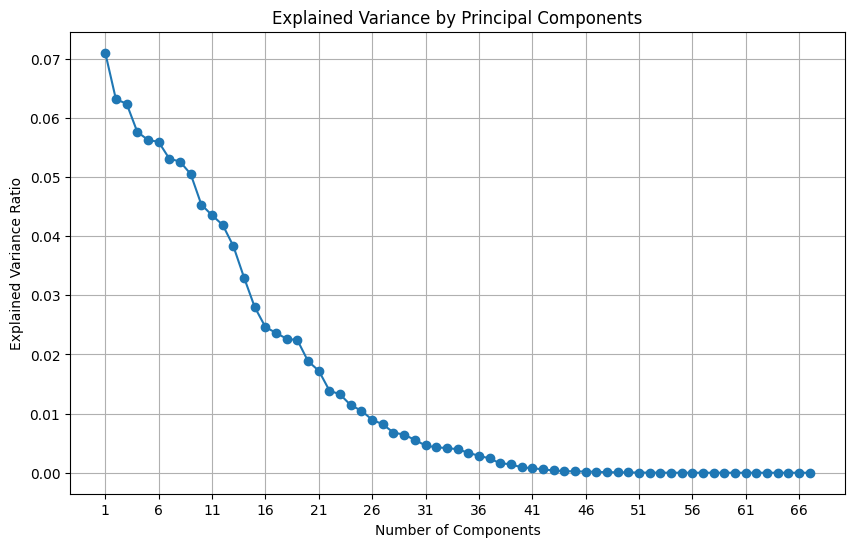


-------------------------------------------------------------------
DataFrame with selected principal components:
            PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0     -0.589118 -0.073230  0.300848 -0.352121  0.947774 -1.174593 -0.275234   
1      0.660204 -0.493407  0.079350  0.359969 -0.668410  0.186249  0.228325   
2      1.981945  0.461828  0.067929  0.569997  0.236721  0.378237  0.132257   
3     -0.004076  0.589775  0.793276  1.011178 -0.563385 -0.951872  0.022848   
4    -16.648915  1.189646 -6.428767 -7.829044  9.034581 -4.473120 -2.314896   
...         ...       ...       ...       ...       ...       ...       ...   
5642   1.523647  1.183488 -0.245440 -0.142316  0.209542  0.441739 -0.441343   
5643   1.609355  0.115790  0.637945  0.136592 -0.169558 -0.291817 -0.268237   
5644   1.776251  0.288022  0.749249  0.344196  0.720573 -0.452346 -0.180665   
5645   1.022346  0.179592  0.425027  0.151463  0.266354 -0.122744  0.020709   
5646   1.741401 

C:\Users\johne\AppData\Local\Temp\ipykernel_33936\3715859956.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_count_dict.keys()), y=list(class_count_dict.values()), palette='pastel')


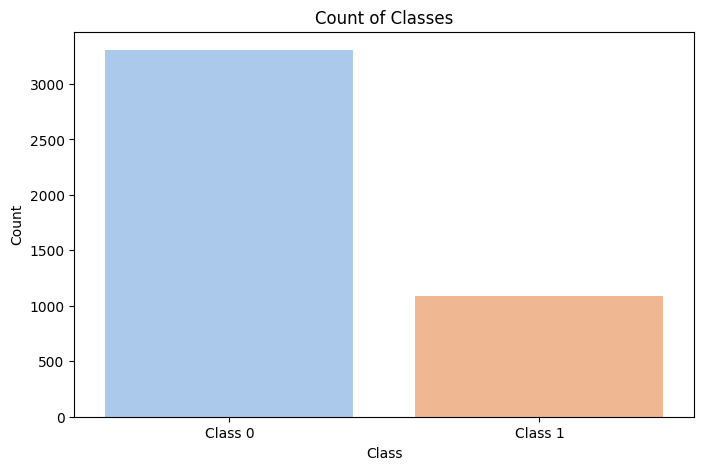


Resampled Dataset Shape: mortality
1.0    3306
0.0    3306
Name: count, dtype: int64

-------------------------------------------------------------------
Accuracy with class weights balanced: 0.72

-------------------------------------------------------------------
Classification Report with class weights balanced (0 - Alive / 1 - Dead):


              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82       850
         1.0       0.42      0.31      0.36       280

    accuracy                           0.72      1130
   macro avg       0.60      0.58      0.59      1130
weighted avg       0.70      0.72      0.71      1130


-------------------------------------------------------------------
Confusion Matrix:
[[728 122]
 [193  87]]

-------------------------------------------------------------------
ROC-AUC Score with class weights balanced: 0.6593


In [3]:
#from google.colab import drive # Loading the Dataset
import pdb
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
import numpy as np # Data Imputation
from sklearn.impute import KNNImputer # KNN Imputation
from imblearn.over_sampling import SMOTE # Data Imputation
from collections import Counter # Data Imputation
from util import *

#from scipy.stats import chi2  Checking for Outliers by Mahalanobis Distance

#drive.mount('/content/drive')
#file_path = '/content/drive/My Drive/COMP7015 AI Project Group/mimiciv_traindata.csv'
file_path = 'data/mimiciv_traindata.csv'
print ('\n-------------------------------------------------------------------')
df = pd.read_csv(file_path)

# KNN Imputation (Imputation for Missing Value)
knn_imputer = KNNImputer(n_neighbors=3)
df_imputed = knn_imputer.fit_transform(df)

# Convert the result back to a DataFrame
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

# Features & Target
X = compute_features(df_imputed.drop('mortality',axis=1)) #df_imputed.drop(columns='mortality')
y = df_imputed['mortality']

print(f'The shape of X is : {pd.DataFrame(X).shape}')
print ('\n-------------------------------------------------------------------')
print(f'The shape of y is : {pd.DataFrame(y).shape}')

# Standardizing the Features by Z-score Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca= pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plot explained variance to decide number of components
print ('\n-------------------------------------------------------------------')
plt.figure(figsize=(10,6))
plt.plot(range(1,len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1, 5))
plt.grid()
plt.show()

# Choose the number of components
n_components = 0.95
cumulative_variance = np.cumsum(explained_variance)
n_components_selected = np.argmax(cumulative_variance >= n_components) + 1

# Transform the dataset to the selected number of components
pca = PCA(n_components = n_components_selected)
X_pca_selected = pca.fit_transform(X_scaled)

# Create a DataFrame with the selected principal components
columns = [f'PC{i+1}' for i in range(n_components_selected)]
df_pca = pd.DataFrame(data = X_pca_selected, columns=columns)

# Concatenate with the target variable
df_after_pca = pd.concat([df_pca, y.reset_index(drop=True)], axis=1)

# Print the resulting DataFrame
print ('\n-------------------------------------------------------------------')
print('DataFrame with selected principal components:')
print(df_after_pca)

# Features & Target
X = df_after_pca.drop(columns='mortality')
y = df_after_pca['mortality']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Outlier Detection with Isolation Forest
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(X_train)

# Predict Outliers (-1 for outlier, 1 for inlier)
iso_outlier_predictions = iso_forest.predict(X_train)

# Identify Outliers
outliers = X_train[iso_outlier_predictions == -1]

# Display Original Data Size and Outliers Found
print ('\n-------------------------------------------------------------------')
print (f'Size of training data: {X_train.shape}')
print (f'Outliers found: {outliers.shape}')

# Calculate & Print Spearman Rank
df_spearman = pd.DataFrame(X_train, columns=[f'PC{i+1}' for i in range(X_train.shape[1])])
df_spearman['is_outlier'] = np.where(iso_outlier_predictions == -1, 1, 0)
df_spearman['mortality'] = y_train.values
spearman_corr, p_value = spearmanr(df_spearman['is_outlier'], df_spearman['mortality'])
print ('\n-------------------------------------------------------------------')
print(f'Spearman Rank Correlation Coefficient: {spearman_corr}')
print(f'P-value: {p_value}')

# Remove Outliers from the Training Data
X_train_cleaned = X_train[iso_outlier_predictions == 1]
y_train_cleaned = y_train[iso_outlier_predictions == 1]
print ('\n-------------------------------------------------------------------')
print(f'Size of Cleaned X:', X_train_cleaned.shape)

# Applying SMOTE (Oversampling Technique)
smote = SMOTE(random_state = 42)
X_resampled, y_resampled = smote.fit_resample(X_train_cleaned, y_train_cleaned)
print ('\n-------------------------------------------------------------------')
print('Original Dataset Shape:', y_train_cleaned.value_counts())

# Count the occurrences of each class
class_counts = y_train_cleaned.value_counts()

# Original and resampled data
class_count_dict = {'Class 0': class_counts.get(0, 0), 'Class 1': class_counts.get(1, 0)}

# Create a bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_count_dict.keys()), y=list(class_count_dict.values()), palette='pastel')

# Add titles and labels
plt.title('Count of Classes')
plt.xlabel('Class')
plt.ylabel('Count')

# Show the plot
plt.xticks(rotation=0)  # Optional: rotate x-axis labels if needed
plt.show()

print('\nResampled Dataset Shape:', y_resampled.value_counts())

# Train the Random Forest Classifier by our training data
classifier = RandomForestClassifier(class_weight='balanced', random_state=42)
classifier.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print ('\n-------------------------------------------------------------------')
print(f'Accuracy with class weights balanced: {accuracy:.2f}')

# Print classification report (includes precision, recall, and F1 score)
print ('\n-------------------------------------------------------------------')
print('Classification Report with class weights balanced (0 - Alive / 1 - Dead):')
print('\n')
print(classification_report(y_test, y_pred))

# Get predicted probabilities for the positive class
y_pred_proba = classifier.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Evaluate the model
print ('\n-------------------------------------------------------------------')
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print ('\n-------------------------------------------------------------------')
print(f'ROC-AUC Score with class weights balanced: {roc_auc:.4f}')